Simply-supported plate undergoing random vibration
===
Defining model
---

In [ ]:
import sys
# extending path to be able to import tudaesasII from the parent directory
sys.path.append('../..')

import numpy as np
from numpy import isclose, pi
from scipy.linalg import cholesky, eigh
from composites import isotropic_plate

from tudaesasII.quad4r import Quad4R, update_K, update_M, DOF, calc_stress

a = 3.
b = 2.
nx = 31
ny = 21

xtmp = np.linspace(0, a, nx)
ytmp = np.linspace(0, b, ny)
xmesh, ymesh = np.meshgrid(xtmp, ytmp)
ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten())).T
x = ncoords[:, 0]
y = ncoords[:, 1]

nids = 1 + np.arange(ncoords.shape[0])
nid_pos = dict(zip(nids, np.arange(len(nids))))
nids_mesh = nids.reshape(nx, ny)
n1s = nids_mesh[:-1, :-1].flatten()
n2s = nids_mesh[1:, :-1].flatten()
n3s = nids_mesh[1:, 1:].flatten()
n4s = nids_mesh[:-1, 1:].flatten()

#plt.plot(x, y, 'o')
#plt.gca().set_aspect('equal')
#plt.show()

E = 70e9 # Pa
nu = 0.33
rho = 2.7e3 # kg/m3
thickness = 0.001 # m
plate = isotropic_plate(thickness=thickness, E=E, nu=nu, calc_scf=True)

Nmdof = DOF*len(ncoords)

K = np.zeros((Nmdof, Nmdof))
M = np.zeros((Nmdof, Nmdof))

quads = []
for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
    pos1 = nid_pos[n1]
    pos2 = nid_pos[n2]
    pos3 = nid_pos[n3]
    pos4 = nid_pos[n4]
    r1 = ncoords[pos1, :2]
    r2 = ncoords[pos2, :2]
    r3 = ncoords[pos3, :2]
    normal = np.cross(r2 - r1, r3 - r2)
    assert normal > 0 # guaranteeing that all elements have CCW positive normal
    quad = Quad4R()
    quad.n1 = n1
    quad.n2 = n2
    quad.n3 = n3
    quad.n4 = n4
    quad.rho = rho
    quad.scf13 = plate.scf_k13
    quad.scf23 = plate.scf_k23
    quad.h = thickness
    quad.A = plate.A
    quad.B = plate.B
    quad.D = plate.D
    quad.Atrans = plate.Atrans
    update_K(quad, nid_pos, ncoords[:, :2], K)
    update_M(quad, nid_pos, ncoords[:, :2], M, lumped=False)
    quads.append(quad)
    
# applying boundary conditions
# simply supported
bk = np.zeros(Nmdof, dtype=bool) #array to store known DOFs
edges = isclose(x, 0.) | np.isclose(x, a) | np.isclose(y, 0) | np.isclose(y, b)
bk[0::DOF][edges] = True
bk[1::DOF][edges] = True
bk[2::DOF][edges] = True

bu = ~bk # same as np.logical_not, defining unknown DOFs

# sub-matrices corresponding to unknown DOFs
Kuu = K[bu, :][:, bu]
Muu = M[bu, :][:, bu]

L = cholesky(M, lower=True)
Linv = np.linalg.inv(L)

Ktilde = Linv @ K @ Linv.T
Ktildeuu = Ktilde[bu, :][:, bu]

num_modes = 35
V = np.zeros((Nmdof, num_modes))
eigvals, Vu = eigh(Ktildeuu, subset_by_index=[0, num_modes-1])
omegans = eigvals**0.5
V[bu] = Vu
P = V
print('Natural frequencies [rad/s]', omegans)



Natural frequencies [rad/s] [  5.83396678  11.26541283  18.03844908  20.3078255   23.81709223
  33.15113338  33.36643443  38.84200142  45.02542862  46.84199861
  50.00486907  55.27805521  64.4260788   69.08419315  69.73215892
  71.18986341  75.83138902  86.50511187  87.03535094  88.5155661
  97.06088848 102.82377794 109.94978645 112.05840476 113.40413506
 117.39609398 123.2784738  128.12006105 129.77072106 140.64796458
 145.71151669 147.20508044 148.86321447 163.17192525 164.93071279]


Defining the three loads
---
F1 -> moment in the xz plane

F2 -> moment in the yz plane

F3 -> normal pressure

In [2]:
# NOTE applying F1 at physical DOFs
F1 = np.zeros(Nmdof, dtype=np.complex128)

unitary_load_1 = 1.

left_mid_nodes = isclose(x, 0) & ~isclose(y, 0) & ~isclose(y, b)
left_corners = isclose(x, 0) & (isclose(y, 0) | isclose(y, b))
right_mid_nodes = isclose(x, a) & ~isclose(y, 0) & ~isclose(y, b)
right_corners = isclose(x, a) & (isclose(y, 0) | isclose(y, b))
F1[3::DOF][left_mid_nodes] = -unitary_load_1/(ny - 1)
F1[3::DOF][left_corners] = -unitary_load_1/(ny - 1)/2
F1[3::DOF][right_mid_nodes] = unitary_load_1/(ny - 1)
F1[3::DOF][right_corners] = unitary_load_1/(ny - 1)/2

# NOTE applying F2 at physical DOFs
F2 = np.zeros(Nmdof, dtype=np.complex128)

unitary_load_2 =  1.

lower_mid_nodes = isclose(y, 0) & ~isclose(x, 0) & ~isclose(x, a)
lower_corners = isclose(y, 0) & (isclose(x, 0) | isclose(x, a))
upper_mid_nodes = isclose(y, b) & ~isclose(x, 0) & ~isclose(x, a)
upper_corners = isclose(y, b) & (isclose(x, 0) | isclose(x, a))
F2[4::DOF][lower_mid_nodes] = -unitary_load_2/(nx - 1)
F2[4::DOF][lower_corners] = -unitary_load_2/(nx - 1)/2
F2[4::DOF][upper_mid_nodes] = unitary_load_2/(nx - 1)
F2[4::DOF][upper_corners] = unitary_load_2/(nx - 1)/2


# NOTE applying F3 at physical DOFs
F3 = np.zeros(Nmdof, dtype=np.complex128)

unitary_load_3 = 1. #pressure 

cg_elem = []
for quad in quads:
    pos1 = nid_pos[quad.n1]
    pos2 = nid_pos[quad.n2]
    pos3 = nid_pos[quad.n3]
    pos4 = nid_pos[quad.n4]
    r1 = ncoords[pos1, :2]
    r2 = ncoords[pos2, :2]
    r3 = ncoords[pos3, :2]
    r4 = ncoords[pos4, :2]
    rc = (r1 + r2 + r3 + r4)/4
    cg_elem.append(rc)
    r12c = (r2 + r1)/2
    r23c = (r3 + r2)/2
    r34c = (r4 + r3)/2
    r41c = (r1 + r4)/2
    def area_i(ra, rb, rc, rd):
        return np.cross(rb - ra, rc - ra)/2 + np.cross(rc - ra, rd - ra)/2
    area1 = area_i(r1, r12c, rc, r41c)
    area2 = area_i(r12c, r2, r23c, rc)
    area3 = area_i(rc, r23c, r3, r34c)
    area4 = area_i(r41c, rc, r34c, r4)
    load1 = unitary_load_3 * area1
    load2 = unitary_load_3 * area2
    load3 = unitary_load_3 * area3
    load4 = unitary_load_3 * area4
    area = np.cross(r2 - r1, r3 - r1)/2 + np.cross(r3 - r1, r4 - r1)/2
    assert np.isclose(area, area1 + area2 + area3 + area4)
    
    F3[pos1*DOF+2] += load1
    F3[pos2*DOF+2] += load2
    F3[pos3*DOF+2] += load3
    F3[pos4*DOF+2] += load4


Modal forces from each unitary load
---

In [3]:
f1 = P.T @ Linv @ F1
f2 = P.T @ Linv @ F2
f3 = P.T @ Linv @ F3

Transfer function
---

In [4]:
def Hi(omegas, omegans, zetas, fi):
    """ based on modal frequency response analysis
    (sinusoidal load)
    """
    omegas = np.atleast_1d(omegas)
    r = np.zeros((num_modes, len(omegas)), dtype=np.complex128)
    for k in range(num_modes):
        H_modal = np.atleast_1d(1/(-omegas**2 + 2*zetas[k]*1j*omegas*omegans[k] + omegans[k]**2))
        r[k] = fi[k] * H_modal
    return r

Cross-power spectrum densities (CSD) of three random load sources
---
Applying the PSD loads according to the consistent DOFs
---


In [5]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

num_loads = 3

tmax = 40
Ntime = 2**14
# NOTE random load oscillation with the amplitudes given below
ampl1 = 20 # [N m]
ampl2 = 20 # [N m]
ampl3 = 2e4 # [Pa]

t = np.linspace(0, tmax, Ntime)
dt = t[1] - t[0]
Fs = 1/dt

# random loading histories in time domain
w1_t = ampl1*(2*np.random.rand(Ntime) - 1)
w2_t = ampl2*(2*np.random.rand(Ntime) - 1)
w3_t = ampl3*(2*np.random.rand(Ntime) - 1)
wi = [w1_t, w2_t, w3_t]

#$plt.figure()
#plt.plot(t, w1_t)

# random loading CSD matrix
window = np.ones(Ntime)
Nfreq = Ntime//2 + 1
Wij = np.zeros((num_loads, num_loads, Nfreq), dtype=np.complex128)
for i in range(num_loads):
    for j in range(num_loads):
        Wij[i, j], freqs_Hz = mlab.csd(wi[i], wi[j], NFFT=Ntime, Fs=Fs,
                                       detrend='none', scale_by_freq=False,
                                       sides='onesided', window=window)
        # NOTE freqs_Hz herein obtained is identical to as np.fft.rfftfreq(Ntime, dt)     


Calculating the displacement PSD
---

In [6]:
r = np.zeros((num_modes, Nfreq), dtype=np.complex128)
zetas = 0.02*np.ones_like(omegans)
flist = [f1, f2, f3]
freqs_rad = freqs_Hz/2/pi
for i in range(num_loads):
    for j in range(num_loads):
        Ha = Hi(freqs_rad, omegans, zetas, flist[i])
        Hb = Hi(freqs_rad, omegans, zetas, flist[j])
        r = r + (Ha * np.conj(Hb) * Wij[i, j])
U = Linv.T @ P @ r

Calculating the stress PSD (sigmaxx for all elements)
---

In [7]:
xy = ncoords[:, :2]

Nxx = np.zeros((len(quads), Nfreq), dtype=np.complex128)

for i, quad in enumerate(quads):
    Nxx_quad, Nyy_quad, Nxy_quad, Mxx_quad, Myy_quad, Mxy_quad, Qx_quad, Qy_quad = calc_stress(quad, U, nid_pos, xy, xi=0.0, eta=0.0)
    Nxx[i] = Nxx_quad + Mxx_quad*thickness/2
    
sigmaxx = Nxx/thickness
# sigmayy = Nyy/thickness

# NOTE one should move forward from this point using Von Mises stresses corrected for the phase difference
#      I am simply using the absolute of sigmaxx

Plotting the stress PSD
---

ready


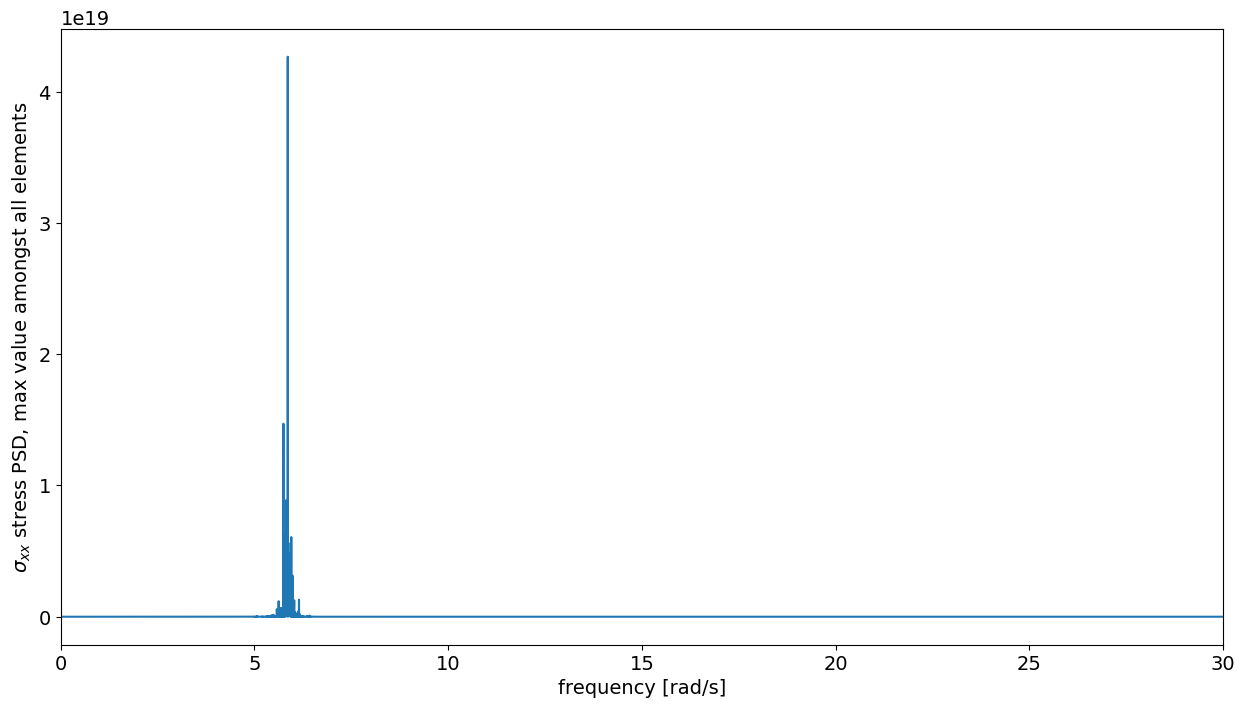

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams['font.size'] = 14

plt.figure(figsize=(15, 8))
plt.plot(freqs_Hz/2/pi, np.max(np.abs(sigmaxx), axis=0))
plt.xlabel('frequency [rad/s]')
plt.ylabel('$\\sigma_{xx}$ stress PSD, max value amongst all elements')
plt.xlim(0, 30)
print('ready')


Stress PSD moments (all elements)
---

In [9]:
PSD = sigmaxx
def moment(n):
    f = freqs_Hz
    f0 = f[:-1]
    f1 = f[1:]
    s0 = PSD[:, :-1]
    s1 = PSD[:, 1:]
    m = ((f0 + f1) / 2) ** n * ((s0 + s1) / 2) * (f1 - f0)
    return m.sum(axis=1)

m0 = moment(0)
m1 = moment(1)
m2 = moment(2)
m4 = moment(4)


Counting method for random PSD
===


Stress levels
---

In [10]:
num_stress_levels = 100

# NOTE defining bins at which damage will be calculated
#      this range should be in accordance with the expected S-N curve of the material
S_Pa = np.linspace(100e6, 400e6, num_stress_levels)
S_MPa = S_Pa/1e6

Fatigue life for different stress levels
---
See DOI: http://dx.doi.org/10.1002/mawe.200800282

$\log_{10} N_{fail} = A - B \log_{10} \left( K_t^E S \left( 2 - \frac{2 S_m}{S} \right)^C - D\right)$

Note that we can assume that:
- $K_t = 1$ given that the stresses are determined from a detailed geometric model.
- $S_m = 0$ given that the random vibration happens around a null mean stress.


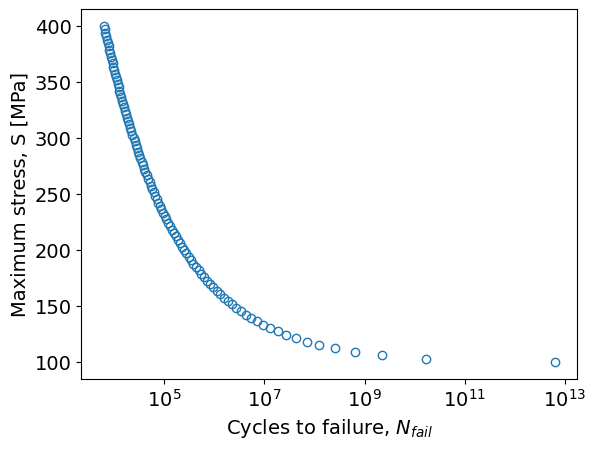

In [11]:
# Parameters A,B,C,D,E for an Aluminium 2024-T3 sheet
# NOTE the stress values should be given in units of MPa
A = 12.81011
B = 3.35997
C = 0.67782
D = 158.9626
E = 0.75416

kt = 1
Sm = 0 # NOTE should be calculated from static loads if necessary

Nfail = 10**(A - B*np.log10(kt**E*S_MPa*(2 - 2*Sm/S_MPa)**C - D))
plt.plot(Nfail, S_MPa, 'o', mfc='none')
plt.ylabel('Maximum stress, S [MPa]')
plt.xlabel('Cycles to failure, $N_{fail}$')
plt.xscale('log')
plt.show()

Probability density function for the random stress (pS)
---

In [12]:
E0 = np.sqrt(m2 / m0) # expected number of zeros
EP = np.sqrt(m4 / m2) # expected number of peaks per second
gamma = E0/EP # irregularity factor

xm = (m1 / m0) * np.sqrt(m2 / m4)
D1 = 2 * (xm - gamma**2) / (1 + gamma**2)
R = (gamma - xm - D1 **2) / (1 - gamma - D1 + D1**2)
D2 = (1 - gamma - D1 + D1**2) / (1 - R)
D3 = 1 - D1 - D2
Q = 1.25 * (gamma - D3 - D2 * R) / D1

Z = S_Pa / (2 * np.sqrt(m0[:, None]))


pS = (( D1[:, None] / Q[:, None]) * np.exp(-Z / Q[:, None])
    + (D2[:, None] * Z / (R[:, None])**2) * np.exp(-Z**2 / (2 * (R[:, None])**2))
    +  D3[:, None] * Z * np.exp(-Z**2 / 2)) / (2 * np.sqrt(m0[:, None]))

Plotting the probability density function
---

Text(0, 0.5, 'pS')

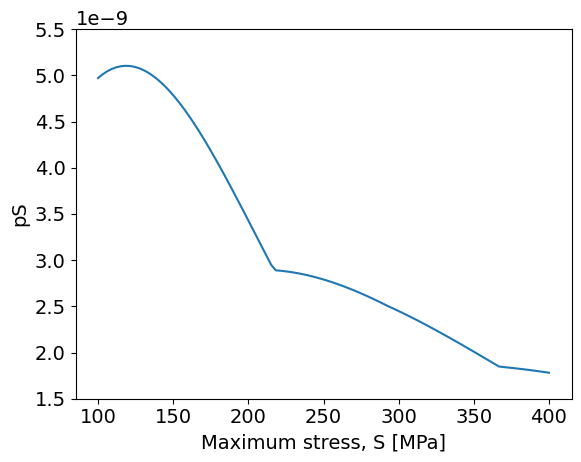

In [13]:
plt.plot(S_MPa, pS.real.max(axis=0))
#for i in range(pS.shape[0]):
#    plt.plot(S_MPa, pS[i])
plt.ylim(1.5e-9, 5.5e-9)
plt.xlabel('Maximum stress, S [MPa]')
plt.ylabel('pS')

Calculating damage for the time of exposure to this random vibration
---

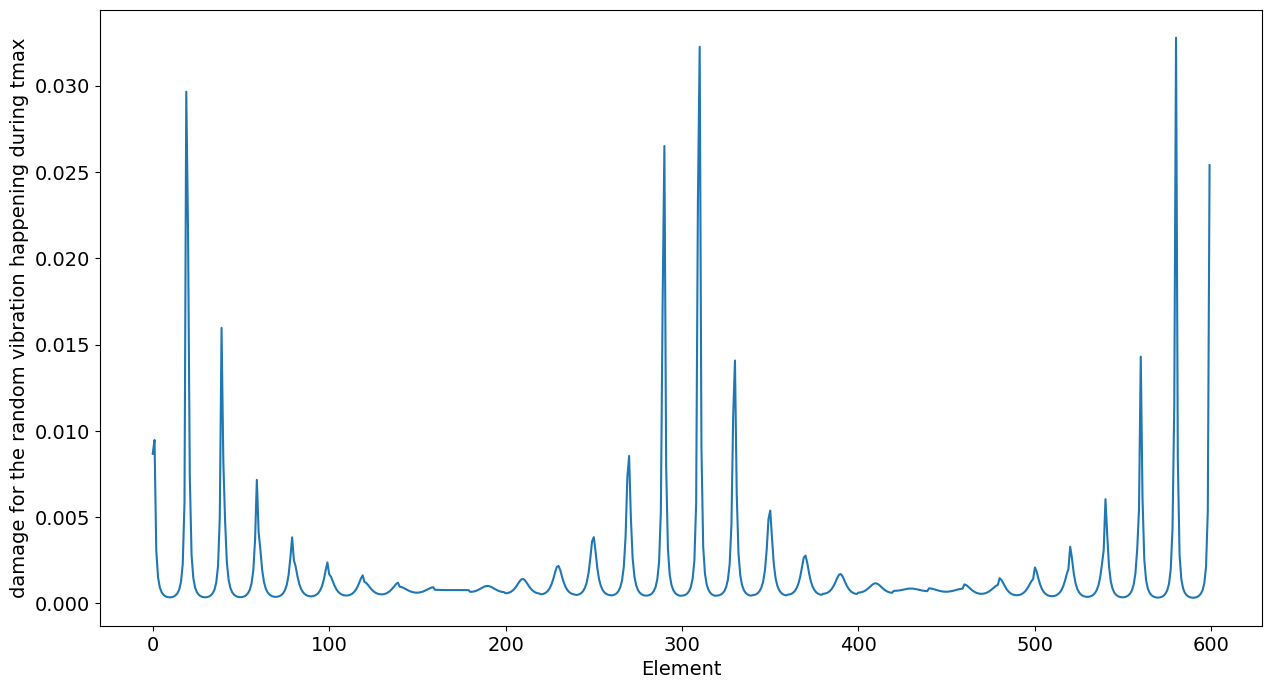

In [14]:
damage = EP * tmax * np.trapz(pS/Nfail, S_Pa, axis=1)
plt.figure(figsize=(15, 8))
plt.plot(damage.real)
plt.xlabel('Element')
plt.ylabel('damage for the random vibration happening during tmax')
pass

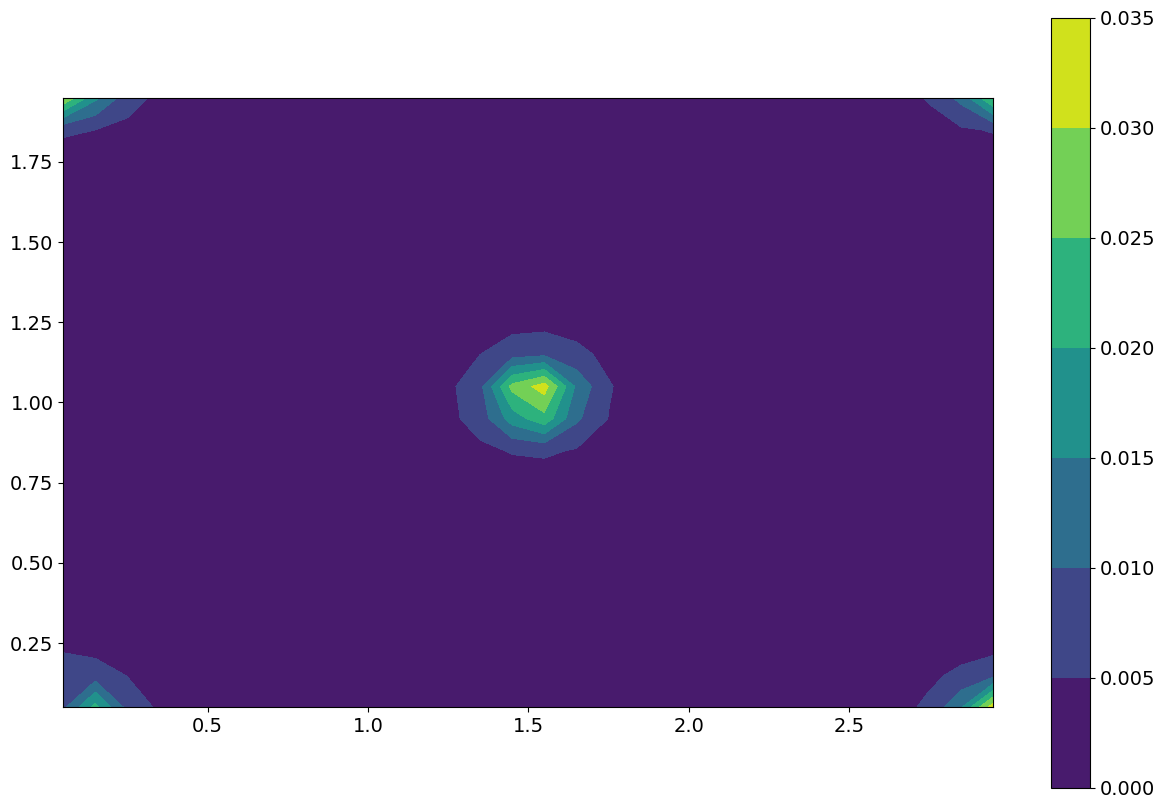

In [15]:
xplot = np.asarray(cg_elem)[:, 0]
yplot = np.asarray(cg_elem)[:, 1]

fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
c = ax.contourf(xplot.reshape(nx-1, ny-1), yplot.reshape(nx-1, ny-1), damage.real.reshape(nx-1, ny-1))
plt.colorbar(c)
ax.set_aspect('equal')
plt.show()


Calculating the time to fail
---

In [16]:
time_to_fail = 1/(damage.real.reshape(nx-1, ny-1)/tmax)
print('min time_to_fail', np.min(time_to_fail), '[s]')

min time_to_fail 1220.4910252165284 [s]
